## 00 Importing Modules

In [1]:
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf

from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

%matplotlib inline

## 01 Importing Dataset

In [2]:
df = pd.read_csv('D:\\Mental_Health_Sentiment.csv', encoding = 'ISO-8859-1')#, sep = ';')
df.shape

(53043, 3)

In [3]:
df.head(2)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety


## 02 Select Variable

In [4]:
x_var = 'statement'
y_var = 'status'

In [5]:
df = df[[x_var, y_var]]
df.head(2)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety


## 03 Data Structuring

In [6]:
df['len'] = df[x_var].apply(lambda x: len(str(x).split()))
df['len'] = df['len'].fillna(0)
df['len'] = df['len'].astype('int')
df.head(2)

,statement,status,len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10


In [7]:
df.dropna(inplace = True)
df.shape

(52681, 3)

## 04 Balancing Data

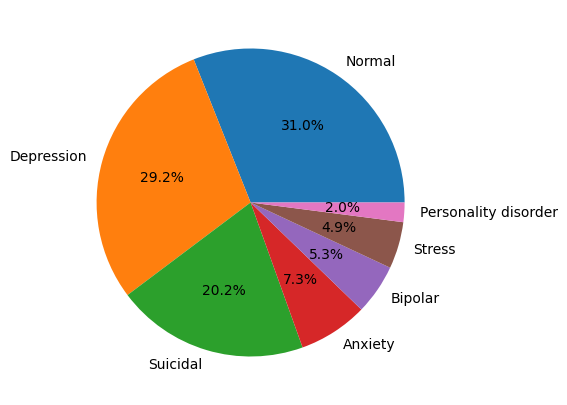

In [8]:
fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in df[y_var].value_counts()]
labels = list(df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show()

In [9]:
n = 1000
append_data = []

for i in df[y_var].unique():
  df_x = df[df[y_var] == i][:n]
  append_data.append(df_x)

In [10]:
append_df = pd.concat(append_data)
append_df.shape

(7000, 3)

In [11]:
append_df.head(2)

,statement,status,len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10


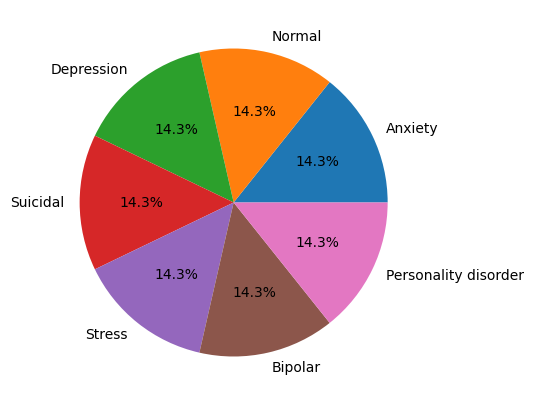

In [12]:
fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in append_df[y_var].value_counts()]
labels = list(append_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show()

## 05 Token Generation

In [13]:
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
#max_length = int(append_df['len'].max())
#max_length = int(append_df['len'].mean())
max_length = 256

#tkn = list(append_df[x_var])
tkn = list(df[x_var])
tkn = bertTokenizer(
  tkn,
  padding = True,
  truncation = True,
  max_length = max_length,
)

In [15]:
# only for generated token preview

df_tkn = pd.DataFrame.from_dict(tkn, orient = 'index').T
df_tkn.head(2)

,input_ids,token_type_ids,attention_mask
0,"[101, 2821, 2026, 2175, 4095, 102, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 4390, 5777, 1010, 5457, 2568, 1010, 1503...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [16]:
txt_ids = np.array(tkn['input_ids'])
txt_tids  = np.array(tkn['token_type_ids'])
txt_am = np.array(tkn['attention_mask'])
#txt_tag = pd.get_dummies(append_df[y_var])
txt_tag = pd.get_dummies(df[y_var])

txt_tag.head(2)

,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False


## 06 Define X & Y Variable, Splitting Dataset

In [17]:
x = txt_ids
y = txt_tag

In [18]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(x, y, test_size = 0.3, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_tosplit, y_tosplit, test_size = 0.4, random_state = 42)

print('x_train shape :', x_train.shape)
print('x_test shape :', x_test.shape)
print('x_val shape :', x_val.shape)

x_train shape : (36876, 256)
x_test shape : (9483, 256)
x_val shape : (6322, 256)


In [19]:
y_classes = len(df[y_var].unique())
y_classes

7

## 07 Create Deep Learning Model

In [20]:
dim = bertTokenizer.vocab_size
dim

30522

In [21]:
inp = layers.Input(shape = (max_length))

x = layers.Embedding(input_dim = dim, output_dim = 64)(inp)
#x = layers.Dense(1024, activation = 'relu', input_dim = dim)(inp)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Conv1D(128, 5, activation = 'relu')(x)
x = layers.LSTM(256, return_sequences = True)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(y_classes, activation = 'softmax')(x)

model = Model(inputs = inp, outputs = x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 64)           1953408   
                                                                 
 dense (Dense)               (None, 256, 512)          33280     
                                                                 
 dense_1 (Dense)             (None, 256, 256)          131328    
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          163968    
                                                                 
 lstm (LSTM)                 (None, 252, 256)          394240    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0     

In [22]:
model.compile(
  loss = 'categorical_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

## 08 Training Model

In [23]:
num_epochs = 50

history = model.fit(
  x_train,
  y_train,
  batch_size = 64,
  epochs = num_epochs,
  validation_data = (x_val, y_val),
  verbose = 1
)

Epoch 1/50
577/577 [==============================] - 39s 51ms/step - loss: 0.9830 - accuracy: 0.5956 - val_loss: 0.8616 - val_accuracy: 0.6327
Epoch 2/50
577/577 [==============================] - 28s 48ms/step - loss: 0.7417 - accuracy: 0.6939 - val_loss: 0.7430 - val_accuracy: 0.6873
Epoch 3/50
577/577 [==============================] - 27s 48ms/step - loss: 0.6143 - accuracy: 0.7488 - val_loss: 0.6738 - val_accuracy: 0.7270
Epoch 4/50
577/577 [==============================] - 28s 48ms/step - loss: 0.5102 - accuracy: 0.7943 - val_loss: 0.6028 - val_accuracy: 0.7668
Epoch 5/50
577/577 [==============================] - 27s 48ms/step - loss: 0.4239 - accuracy: 0.8289 - val_loss: 0.6226 - val_accuracy: 0.7661
Epoch 6/50
577/577 [==============================] - 27s 48ms/step - loss: 0.3683 - accuracy: 0.8513 - val_loss: 0.6460 - val_accuracy: 0.7615
Epoch 7/50
577/577 [==============================] - 28s 48ms/step - loss: 0.3199 - accuracy: 0.8720 - val_loss: 0.6915 - val_accuracy:

KeyboardInterrupt: 

## 09 Model Evaluation

In [ ]:
model.evaluate(x_test, y_test)

297/297 [==============================] - 1s 3ms/step - loss: 3.0549 - accuracy: 0.4887


[3.054936647415161, 0.488663911819458]

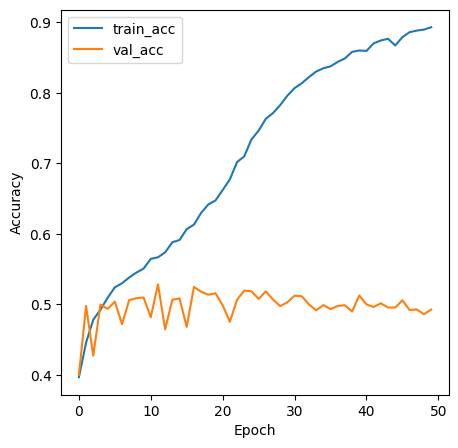

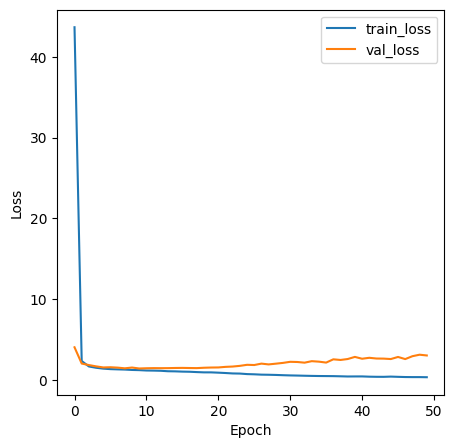

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (5, 5))
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()